In [ ]:
#References

#1)http://krasserm.github.io/2019/09/04/super-resolution/
#2)https://github.com/sumittagadiya/Image-super-resolution

In [1]:
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.experimental import AUTOTUNE
import tensorflow_datasets as tfds
import time
import numpy as np

from sewar.full_ref import uqi
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from PIL import Image
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
#checking if gpu is available or not
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  0
2.6.0


'3.8.3 (default, Jul  2 2020, 16:21:59) \n[GCC 7.3.0]'

In [3]:
# download and preparing the data set with bicubic_x4 downgrading factor
div2k = tfds.image.Div2k(config='bicubic_x4')
div2k.download_and_prepare()

# train data

ds_train = div2k.as_dataset(split='train',as_supervised=True)
# validation data
ds_valid = div2k.as_dataset(split='validation',as_supervised=True)

In [4]:
ds_train = div2k.as_dataset(split='train',as_supervised=True)
ds_valid = div2k.as_dataset(split='validation',as_supervised=True)

In [5]:
d_train = ds_train.cache()
d_valid = ds_valid.cache()

In [6]:
print('Train cardinality = ',ds_train.cardinality().numpy())
print('Validation cardinality',ds_valid.cardinality().numpy())

Train cardinality =  800
Validation cardinality 100


In [7]:
#functions to do the data augmentation
def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    ''' This function crops lr(47x47) and hr(96x96) images'''
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

def random_flip(lr_img, hr_img):
    ''' This function will flip imag left_right randomly'''
    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))
        
def random_rotate(lr_img, hr_img):
    ''' This function will rotate image randomly to 90 degree'''
    rand = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rand), tf.image.rot90(hr_img, rand)

In [8]:
#this function does the preprocessing the data and increasing the training dataset
def preprocessing(data, batch_size=4,scale=4,repeat_count=None, random_transform=True):
        # This random transform will apply only on train dataset
        if random_transform:
            #cropping randomly
            data = data.map(lambda lr, hr: random_crop(lr, hr, scale=scale),num_parallel_calls=tf.data.AUTOTUNE)
            #rotating randomly
            data = data.map(random_rotate,num_parallel_calls=tf.data.AUTOTUNE)
            #flipping randomly
            data = data.map(random_flip,num_parallel_calls=tf.data.AUTOTUNE)
        # taking images in given batch size
        data = data.batch(batch_size)
        # repeating the dataset. if repeat_count() = None then infinite cardinality
        data = data.repeat(repeat_count)
        # prefetching the data for given buffer_size
        data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
        return data

# train data with infinite cardinality
train_preprocessed = preprocessing(ds_train)
# validation data with cardinality 100
valid_preprocessed = preprocessing(ds_valid,batch_size=1,repeat_count=1,random_transform=False)

In [7]:
def plot_images(tf_dataset,n_rows,figsize=(30,30)):
    # subplots
    fig,axes = plt.subplots(nrows =n_rows, ncols = 2, figsize=figsize)
    for ax in axes.flatten():
        ax.axis('off')
    count = -1
    for lr, hr in tf_dataset.take(n_rows).as_numpy_iterator():
        count+=1
        print('LR Shape is {} and HR shape is {}'.format(lr[0].shape,hr[0].shape))
        axes[count,0].set_title('Low resolution',fontdict={'fontsize': 20,'fontweight': 'bold'})
        axes[count,0].imshow(lr[0])
        axes[count,1].set_title('High Resolution',fontdict={'fontsize': 20,'fontweight': 'bold'})
        axes[count,1].imshow(hr[0])

LR Shape is (24, 24, 3) and HR shape is (96, 96, 3)
LR Shape is (24, 24, 3) and HR shape is (96, 96, 3)


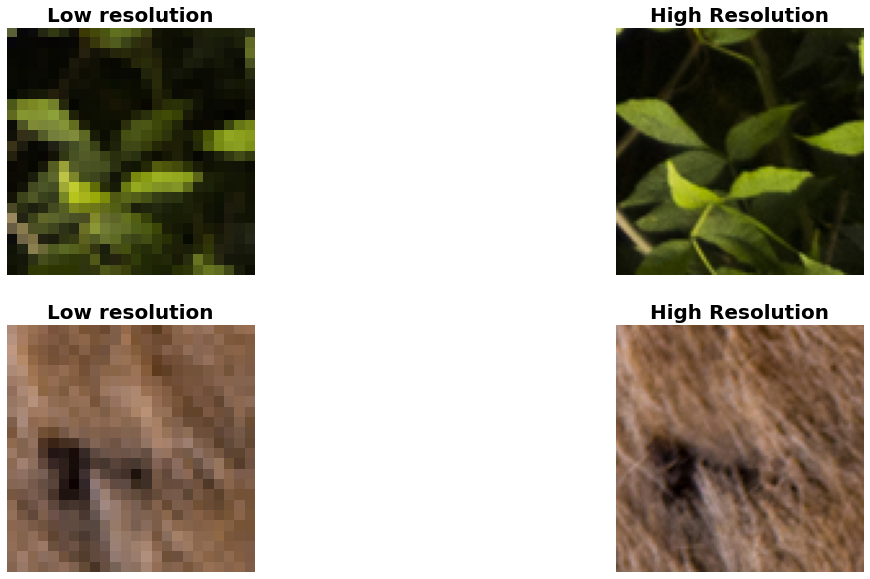

In [10]:
plot_images(train_preprocessed,n_rows=2,figsize=(20,10))

LR Shape is (510, 417, 3) and HR shape is (2040, 1668, 3)
LR Shape is (393, 510, 3) and HR shape is (1572, 2040, 3)


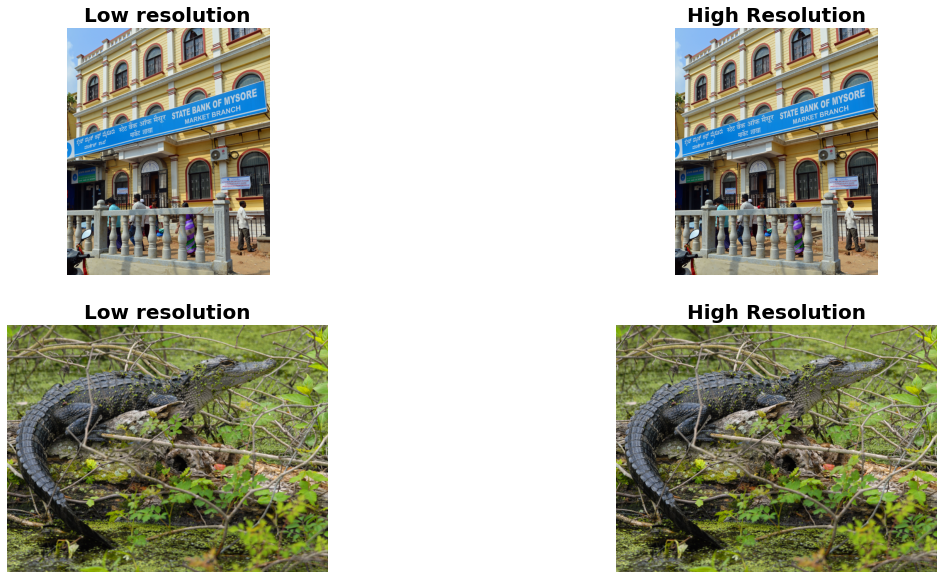

In [11]:
plot_images(valid_preprocessed,n_rows=2,figsize=(20,10))

PSNR value ==>  24.899313
SSIM value ==>  0.8498668


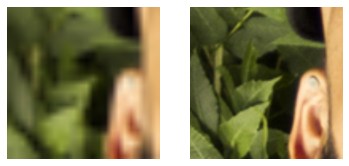

In [ ]:
fig,axes = plt.subplots(nrows =1, ncols = 2)
for ax in axes.flatten():
        ax.axis('off')
for lr,hr in train_preprocessed:
  
    LR = tf.image.resize(lr, size=(512,512))
    HR = tf.image.resize(hr, size=(512,512))
    
    LR = tf.clip_by_value(LR, 0, 255)
    HR = tf.clip_by_value(HR, 0, 255)

    # rounding up values
    LR = tf.round(LR)
    HR = tf.round(HR)

    # changing the data type to unint8
    LR = tf.cast(LR, tf.uint8)
    HR = tf.cast(HR, tf.uint8)

    axes[0].imshow(LR[0])
    axes[1].imshow(HR[0])
    
    #calculating PSNR value
    psnr_value = tf.image.psnr(HR, LR, max_val=255).numpy()

    #calculating SSIM value
    ssim = tf.image.ssim(HR,LR,max_val=255)
    
    print('PSNR value ==> ',psnr_value[0])
    print("SSIM value ==> ",ssim.numpy()[0])
    break

PSNR value ==>  24.716297
SSIM value ==>  0.8525074


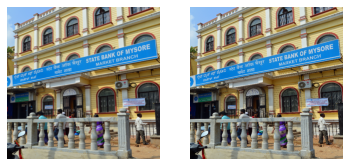

In [ ]:
fig,axes = plt.subplots(nrows =1, ncols = 2)
for ax in axes.flatten():
        ax.axis('off')
for lr,hr in valid_preprocessed :
  
    LR = tf.image.resize(lr, size=(512,512))
    HR = tf.image.resize(hr, size=(512,512))

    LR = tf.clip_by_value(LR, 0, 255)
    HR = tf.clip_by_value(HR, 0, 255)
    # rounding up the values
    LR = tf.round(LR)
    HR = tf.round(HR)

    # changing the data type to unint8
    LR = tf.cast(LR, tf.uint8)
    HR = tf.cast(HR, tf.uint8)
  
    axes[0].imshow(LR[0])
    axes[1].imshow(HR[0])

    #calaculating PSNR value
    psnr_value = tf.image.psnr(HR, LR, max_val=255).numpy()

    #calculating SSIM value
    ssim = tf.image.ssim(HR,LR,max_val=255)
    print('PSNR value ==> ',psnr_value[0])
    print("SSIM value ==> ",ssim.numpy()[0])
    break

In [9]:
########################################## EDSR MODEL #####################################
def EDSR(scale, num_filters=64, res_blocks=16, res_block_scaling=None):
    x_input = Input(shape=(None, None, 3))

    # Normalization of input using DIV2K_RGB_MEAN
    x = Lambda(normalize)(x_input)
    
    # assign value of x to x_res block for further operations
    x = x_res_block = Conv2D(num_filters, 3, padding='same')(x)

    # runs according to number of residual blocks
    for i in range(res_blocks):
        x_res_block = ResBlock(x_res_block, num_filters, res_block_scaling)

    # convolution
    x_res_block = Conv2D(num_filters, 3, padding='same')(x_res_block)
    # add residual block output and original normalized input
    x = Add()([x, x_res_block])

    # upsampling
    x = Upsampling(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)
    
    # denormalization to get back original form
    x = Lambda(denormalize)(x)
    return Model(x_input, x, name="EDSR")
  
################################## ResBlock Architecture ################################
def ResBlock(x_input, num_filters, scaling):
    '''This function Implementes Proposed ResBlock Architecture as per EDSR paper'''
    # proposed ResBlock ==> Conv --> Relu --> Conv --> Scaling(mul) --> Add
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x_input)
    x = Conv2D(num_filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x
######################################### Upsampling #######################################
def Upsampling(x, scale, num_filters):
    '''This function upsampling as mentioned in EDSR paper'''
    def upsample(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(shuffle_pixels(scale=factor))(x)

    if scale == 2:
        x = upsample(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample(x, 2, name='conv2d_1_scale_2')
        x = upsample(x, 2, name='conv2d_2_scale_2')

    return x

############################ Normalize, Denormalize and pixel shuffle functions #########################
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255
def normalize(x,rgb_mean=DIV2K_RGB_MEAN):
    '''This function will normalize image by substracting RGB mean from image'''
    return (x - rgb_mean) / 127.5

def denormalize(x,rgb_mean=DIV2K_RGB_MEAN):
    ''' This function will denormalize image by adding back rgb_mean'''
    return (x * 127.5 )+ rgb_mean

def shuffle_pixels(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [10]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5




# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

**SRGAN**

In [11]:


LR_SIZE = 24
HR_SIZE = 96


def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def res_block(x_in, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([x_in, x])
    return x


def sr_resnet(num_filters=64, num_res_blocks=16):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize_01)(x_in)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = res_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    x = upsample(x, num_filters * 4)
    x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_m11)(x)

    return Model(x_in, x)


generator = sr_resnet


def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    return LeakyReLU(alpha=0.2)(x)

#discriminator function
def discriminator(num_filters=64):
    x_in = Input(shape=(HR_SIZE, HR_SIZE, 3))
    x = Lambda(normalize_m11)(x_in)

    x = discriminator_block(x, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = Flatten()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(x_in, x)


def vgg_22():
    return _vgg(5)


def vgg_54():
    return _vgg(20)

#Very Deep Convolutional Networks for Large-Scale Image Recognition 
# https://arxiv.org/abs/1409.1556
def _vgg(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)



**Modifiying the EDSR using SRGAN**

In [12]:
#means squared error 
MSE = tf.keras.losses.MeanSquaredError()
weights_directory = 'Weights/'
#Binary cross entropy which will be used in gen_loss and disc_loss
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# This Model computes the feature map after the 4th convolution.This is layer 20 in the corresponding Keras model.
vgg = vgg_54()

# EDSR model used as generator in SRGAN
generator = EDSR(scale=4, res_blocks=16)
generator.load_weights(os.path.join(weights_directory, 'EDSR_weights.h5'))

# SRGAN discriminator
discr = discriminator()


# 1000 steps are used and learning rate is reduced from 0.001 to 0.0001 after
# 500 steps
train_schedule = PiecewiseConstantDecay(boundaries=[500], values=[1e-3, 1e-4])

#optimizer for the generator
gen_optimizer = Adam(learning_rate=train_schedule)

#optimizer for the dicriminator
disc_optimizer = Adam(learning_rate=train_schedule)

#function to calculate the discriminator loss
def disc_loss(HR_out, SR_out):
    HR_loss = BCE(tf.ones_like(HR_out), HR_out)
    SR_loss = BCE(tf.zeros_like(SR_out), SR_out)
    return HR_loss + SR_loss

#Function to calculate the generator loss
def gen_loss(SR_out):
    return BCE(tf.ones_like(SR_out), SR_out)

#this function returns content loss of generated super resolution image and high resolution image
#using mean squared error
def content_loss(HR, SR):
    # convert the input images from RGB to BGR and zero-center the each color channel with respect to the ImageNet dataset
    SR = tf.keras.applications.vgg19.preprocess_input(SR)
    HR = tf.keras.applications.vgg19.preprocess_input(HR)

    SR_features = vgg(SR) / 12.75
    HR_features = vgg(HR) / 12.75
    return MSE(HR_features, SR_features)



#this function is SRGAN training step function.
#Takse HR and LR image batch as input and outputs computed preceptual loss and discrimiator loss
def train_step(LR, HR):
  
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminatior_tape:
        #casting to data type tf.float32
        LR = tf.cast(LR, tf.float32)
        HR = tf.cast(HR, tf.float32)

        #generating SR image using EDSR model
        SR = generator(LR, training=True)

        #Getting dicriminator outputs from HR and SR images
        HR_output = discr(HR, training=True)
        SR_output = discr(SR, training=True)

       
        cont_loss = content_loss(HR, SR) #getting content loss
        generator_loss = gen_loss(SR_output) #getting generator loss
        perc_loss = cont_loss + 0.001 * generator_loss #calculating perceptual loss
        discriminator_loss = disc_loss(HR_output, SR_output) #getting dicriminatior loss

    # Computing the gradient of perceptual loss with respect to generator weights 
    gradients_of_generator = generator_tape.gradient(perc_loss, generator.trainable_variables)
    # Computing gradient of discriminator loss with respect to discriminator weights 
    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discr.trainable_variables)

    # Updating the weights of generator and discriminator
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discr.trainable_variables))

    return perc_loss, discriminator_loss



**Training the model**

In [ ]:
#Training the model

#initializing metrics
perc_ls_metric = tf.keras.metrics.Mean()
disc_ls_metric = tf.keras.metrics.Mean()

steps = 1000
step = 0

# Training the SRGAN for 1000 steps
for LR, HR in tqdm(train_preprocessed.take(steps)):
    step += 1

    pl, dl = train_step(LR, HR)
    perc_ls_metric(pl)
    disc_ls_metric(dl)
    
    #print(f'{step}/{steps}, perceptual loss = {perc_ls_metric.result():.4f}, discriminator loss = {disc_ls_metric.result():.4f}')
    if step % 50 == 0:
        print(f'{step}/{steps}, perceptual loss = {perc_ls_metric.result():.4f}, discriminator loss = {disc_ls_metric.result():.4f}')
        perc_ls_metric.reset_states()
        disc_ls_metric.reset_states()
#saving the trained weights for fine tuned edsr     
generator.save_weights(os.path.join(weights_directory, 'weights_edsr_16_x4_fine_tuned_SRGAN.h5'))

50/1000, perceptual loss = 0.1260, discriminator loss = 9.0791
100/1000, perceptual loss = 0.1446, discriminator loss = 3.7788
150/1000, perceptual loss = 0.1276, discriminator loss = 3.0071
200/1000, perceptual loss = 0.1271, discriminator loss = 1.8495
250/1000, perceptual loss = 0.1415, discriminator loss = 1.6326
300/1000, perceptual loss = 0.1299, discriminator loss = 1.5762
350/1000, perceptual loss = 0.1342, discriminator loss = 1.4996
400/1000, perceptual loss = 0.1285, discriminator loss = 1.4510
450/1000, perceptual loss = 0.1134, discriminator loss = 1.5102
500/1000, perceptual loss = 0.1161, discriminator loss = 1.4934
550/1000, perceptual loss = 0.1254, discriminator loss = 1.4242
600/1000, perceptual loss = 0.1073, discriminator loss = 1.4018
650/1000, perceptual loss = 0.0937, discriminator loss = 1.4056
700/1000, perceptual loss = 0.1066, discriminator loss = 1.3959
750/1000, perceptual loss = 0.1075, discriminator loss = 1.3921
800/1000, perceptual loss = 0.1031, discr

In [13]:
#Resolving the image according to the weights of the model
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

def load_image(path):
    return np.array(Image.open(path))

In [14]:
#Function to plot the results
def plot_results(model_pre_trained, model_fine_tuned, LR_image_path, HR_image_path):
    LR = load_image(LR_image_path)
    HR = load_image(HR_image_path)
    
    SR_pt = resolve_single(model_pre_trained, LR)
    SR_ft = resolve_single(model_fine_tuned, LR)
    
    #calculating PSNR value
    psnr_EDSR_pretrained = tf.image.psnr(HR, SR_pt, max_val=255).numpy()
    psnr_fine_tuned = tf.image.psnr(HR, SR_ft, max_val=255).numpy()
    
    #calculating UQI value
    uqi_EDSR_pretrained = uqi(HR, SR_pt.numpy())
    uqi_fine_tuned = uqi(HR, SR_ft.numpy())
    
    #calculating SSIM value
    ssim_EDSR_pretrained = tf.image.ssim(HR, SR_pt,max_val=255)
    ssim_fine_tuned = tf.image.ssim(HR, SR_ft,max_val=255)
    
    plt.figure(figsize=(20, 20))
    

    images = [LR, SR_pt, SR_ft]
    titles = [f'LR original', f'SR (Pre trained EDSR) \n PSNR = {psnr_EDSR_pretrained } \n SSIM = {ssim_EDSR_pretrained} \n UQI = {uqi_EDSR_pretrained})', f'SR (Fine tuned by SRGAN) \n PSNR = { psnr_fine_tuned }\n SSIM = { ssim_fine_tuned}\n UQI = {uqi_fine_tuned})']
    positions = [1, 3, 4]
    
    for i, (image, title, position) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, position)
        plt.imshow(image)
        plt.title(title, fontsize = 20)
        plt.xticks([])
        plt.yticks([])
        


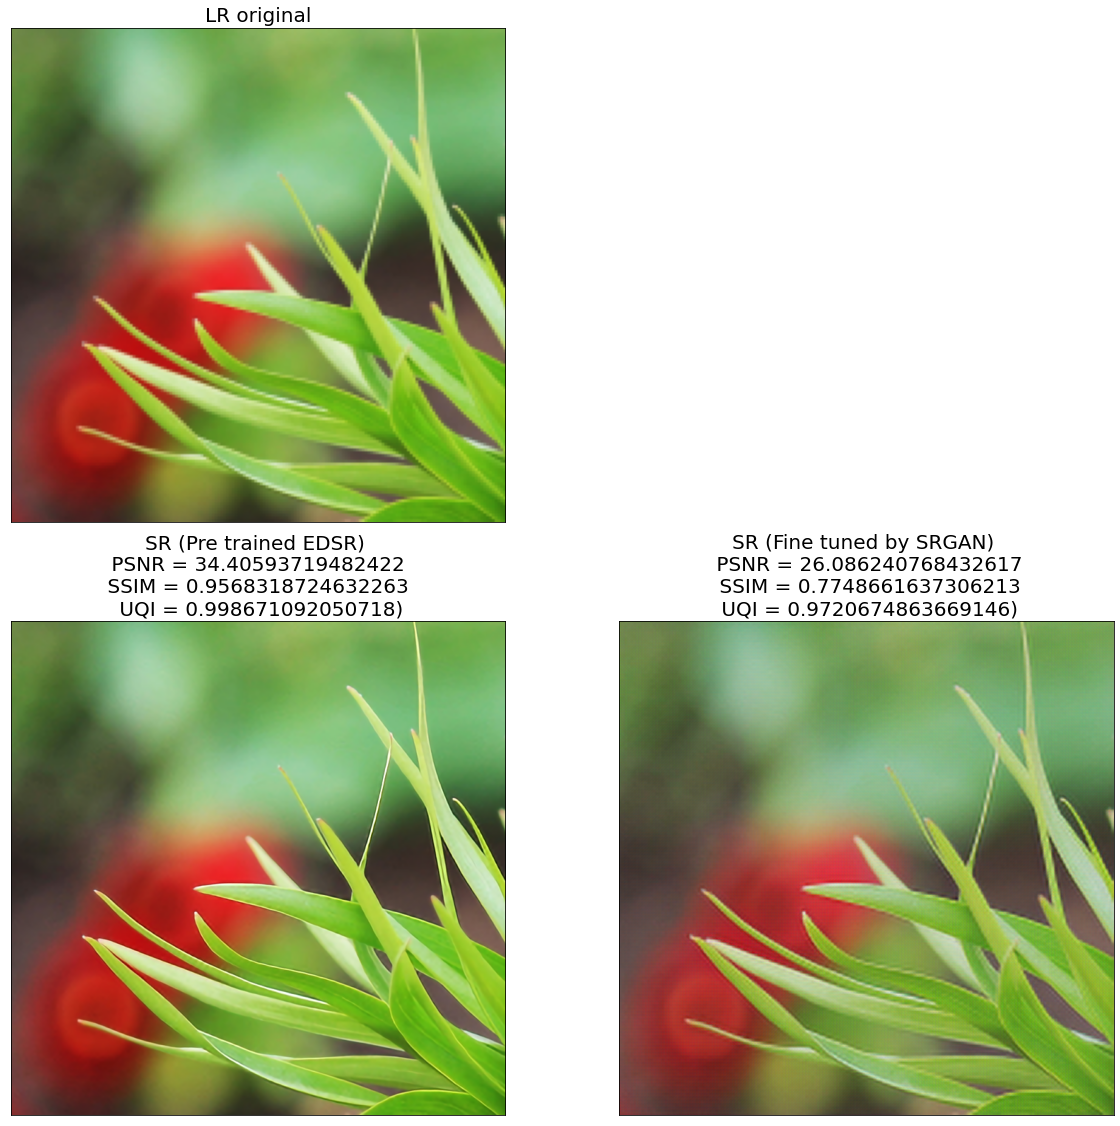

In [15]:
#generating SR image from LR for edsr and fine tuned edsr by srgan
edsr_pretrained = EDSR(scale=4, res_blocks=16)
edsr_pretrained.load_weights(os.path.join(weights_directory, 'EDSR_weights.h5'))

srgan_finetuned_edsr = EDSR(scale=4, res_blocks=16)
srgan_finetuned_edsr.load_weights(os.path.join(weights_directory, 'weights_edsr_16_x4_fine_tuned_SRGAN.h5'))

plot_results(edsr_pretrained, srgan_finetuned_edsr, 'Images/LR_3.png', 'Images/HR_3.png')

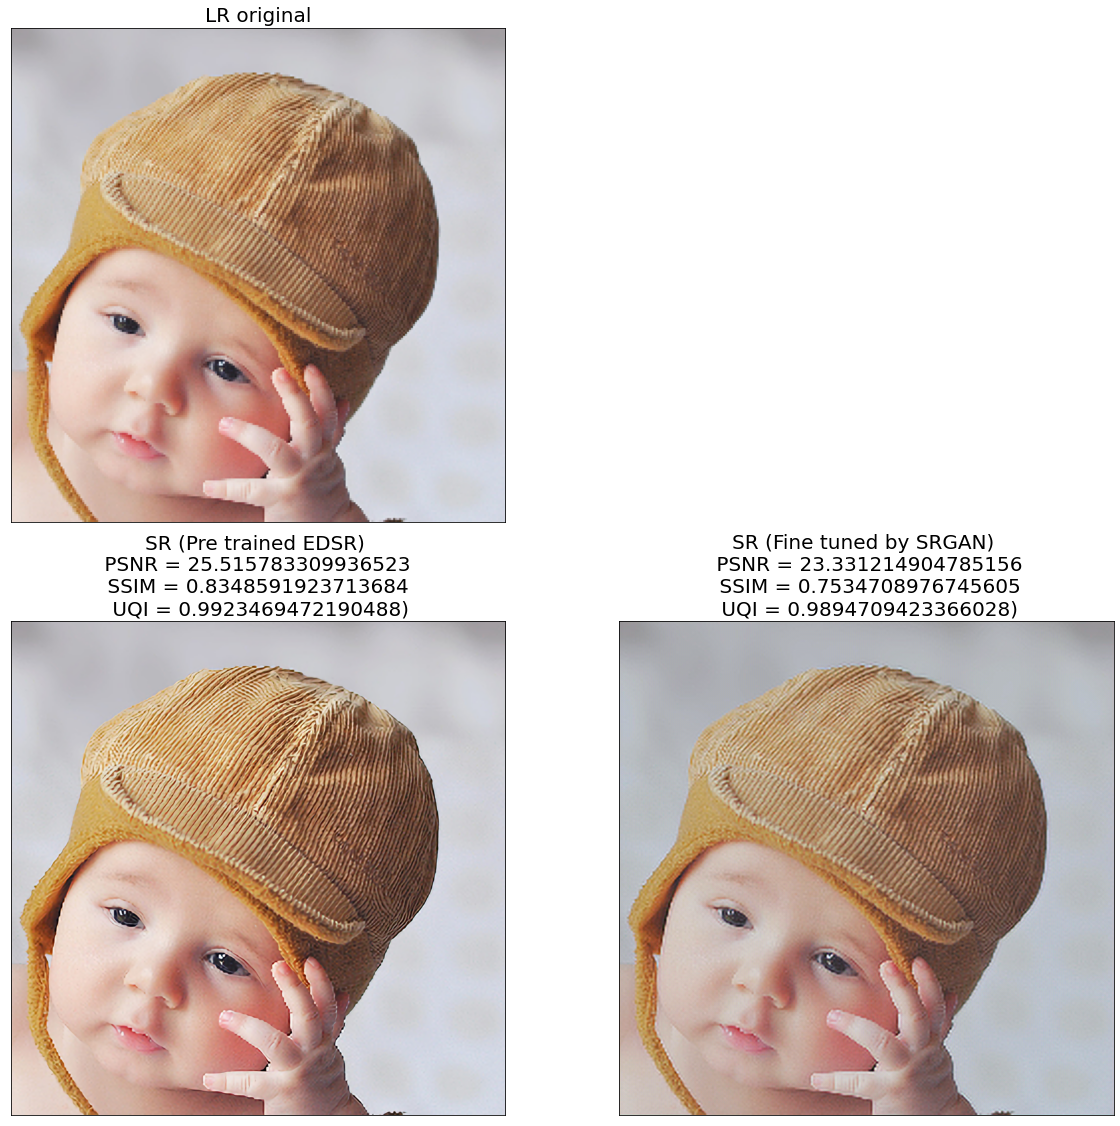

In [16]:
#getting result for human image
edsr_pretrained = EDSR(scale=4, res_blocks=16)
edsr_pretrained.load_weights(os.path.join(weights_directory, 'EDSR_weights.h5'))

srgan_finetuned_edsr = EDSR(scale=4, res_blocks=16)
srgan_finetuned_edsr.load_weights(os.path.join(weights_directory, 'weights_edsr_16_x4_fine_tuned_SRGAN.h5'))

plot_results(edsr_pretrained, srgan_finetuned_edsr, 'Images/babylr.png', 'Images/babyhr.png')